In [84]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [85]:
# GeomeTRe calculated parameters
geometre_df = pd.read_csv("data/output_repeatsdb4_geometre.csv")
geometre_df

,pdb_id,chain,region_start_mean,region_end_mean,curvature_mean,twist_mean,twist_hand_mean,pitch_mean,pitch_hand_mean,tmscore_mean,yaw_mean,region_start_std,region_end_std,curvature_std,twist_std,twist_hand_std,pitch_std,pitch_hand_std,tmscore_std,yaw_std
0,==> data/batch/result_batch_00.csv <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4gyx,A,1.0,28.0,0.144,0.815,1.000,0.114,0.000,0.967,0.063,1.0,28.0,0.007,0.138,0.000,0.082,1.000,0.083,0.035
2,4gyx,B,1.0,28.0,0.129,0.763,1.000,0.183,0.250,0.905,0.086,1.0,28.0,0.017,0.237,0.000,0.108,0.968,0.126,0.052
3,4gyx,C,1.0,26.0,0.144,0.806,1.000,0.119,0.143,0.958,0.101,1.0,26.0,0.006,0.116,0.000,0.088,0.990,0.086,0.174
4,6bl7,B,659.0,741.0,0.138,1.259,-0.500,0.048,0.500,0.763,0.090,659.0,741.0,0.011,0.517,0.866,0.046,0.866,0.048,0.078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14986,5zi5,A,449.0,862.0,0.330,0.750,-0.200,0.410,-0.200,0.368,0.377,449.0,862.0,0.156,0.822,0.980,0.253,0.980,0.119,0.428
14987,3zr6,A,41.0,337.0,0.848,0.533,-0.714,0.297,-0.429,0.311,0.506,41.0,337.0,0.193,0.388,0.700,0.136,0.904,0.059,0.640
14988,5zsx,A,12.0,270.0,1.456,3.042,0.333,0.203,-0.333,0.495,2.794,12.0,270.0,0.209,0.081,0.943,0.053,0.943,0.019,0.272
14989,4zu9,A,207.0,345.0,1.245,0.486,1.000,0.274,0.000,0.208,1.886,207.0,345.0,0.975,0.007,0.000,0.003,1.000,0.067,0.939


In [86]:
# List of designed RepeatDB proteins
designed_df = pd.read_csv('data/repeatsdb4_designed.tsv', sep='\t')
designed_df['designed'] = True
designed_df

,pdb_id,chain,designed
0,4r58,A,True
1,4r58,B,True
2,4r58,C,True
3,4r58,D,True
4,4r5c,A,True
...,...,...,...
127,5xg5,A,True
128,5byo,A,True
129,5byo,B,True
130,4yxx,A,True


In [87]:
with open('data/repeatsdb4_classification.json') as f:
        obj = json.load(f)
        df_rdb = pd.json_normalize(obj, ["content", "loci"], [["content", "chain", "structure"], ["content", "chain", "id"]], errors='ignore')

df_rdb['pdb_id'] = df_rdb['content.chain.structure']
df_rdb['chain'] = df_rdb['content.chain.id']
df_rdb = df_rdb[['pdb_id', 'chain', 'start', 'end', 'class']]
df_unit_count = df_rdb.loc[df_rdb['class'].str.len()==0].groupby(['pdb_id', 'chain'], as_index=False)['class'].count()
df_unit_count.rename(columns={'class': "unit_count"}, inplace=True)
df_rdb = df_rdb.loc[df_rdb['class'].str.len()>0]  # Filter out units and keep regions
df_rdb = pd.merge(df_rdb, df_unit_count, on=['pdb_id', 'chain'], how='left')
df_rdb

,pdb_id,chain,start,end,class,unit_count
0,1a0c,A,42,375,4.1.1,8
1,1a0d,A,41,372,4.1,8
2,1a0e,A,43,375,4.1,8
3,1a0r,B,55,340,4.4.1.1,7
4,1a0t,P,73,483,4.2,17
...,...,...,...,...,...,...
15189,2zzk,B,100,692,4.4.1.2,14
15190,2zzl,A,9,194,3.3,4
15191,4zz9,A,7,224,4.1.1.1,9
15192,4zz9,B,9,208,4.1.1.1,7


In [88]:
df = pd.merge(geometre_df, df_rdb, how='left', on=['pdb_id', 'chain'])
df = pd.merge(df, designed_df, how='left', on=['pdb_id', 'chain'])
df['class'] = df['class'].astype(str)
# df.columns = df.columns.str.strip()
# df['pitch_mean'] = pd.to_numeric(df['pitch_mean'], errors='coerce')
# df['pitch_std'] = pd.to_numeric(df['pitch_std'], errors='coerce')
df

,pdb_id,chain,region_start_mean,region_end_mean,curvature_mean,twist_mean,twist_hand_mean,pitch_mean,pitch_hand_mean,tmscore_mean,...,twist_hand_std,pitch_std,pitch_hand_std,tmscore_std,yaw_std,start,end,class,unit_count,designed
0,==> data/batch/result_batch_00.csv <==,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,NaN
1,4gyx,A,1.0,28.0,0.144,0.815,1.000,0.114,0.000,0.967,...,0.000,0.082,1.000,0.083,0.035,1,28,2.1,9.0,NaN
2,4gyx,B,1.0,28.0,0.129,0.763,1.000,0.183,0.250,0.905,...,0.000,0.108,0.968,0.126,0.052,1,28,2.1,9.0,NaN
3,4gyx,C,1.0,26.0,0.144,0.806,1.000,0.119,0.143,0.958,...,0.000,0.088,0.990,0.086,0.174,1,26,2.1,8.0,NaN
4,6bl7,B,659.0,741.0,0.138,1.259,-0.500,0.048,0.500,0.763,...,0.866,0.046,0.866,0.048,0.078,659,741,2.2,5.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15547,5zi5,A,449.0,862.0,0.330,0.750,-0.200,0.410,-0.200,0.368,...,0.980,0.253,0.980,0.119,0.428,449,525,4.2,13.0,NaN
15548,3zr6,A,41.0,337.0,0.848,0.533,-0.714,0.297,-0.429,0.311,...,0.700,0.136,0.904,0.059,0.640,NaN,NaN,nan,NaN,NaN
15549,5zsx,A,12.0,270.0,1.456,3.042,0.333,0.203,-0.333,0.495,...,0.943,0.053,0.943,0.019,0.272,NaN,NaN,nan,NaN,NaN
15550,4zu9,A,207.0,345.0,1.245,0.486,1.000,0.274,0.000,0.208,...,0.000,0.003,1.000,0.067,0.939,NaN,NaN,nan,NaN,NaN


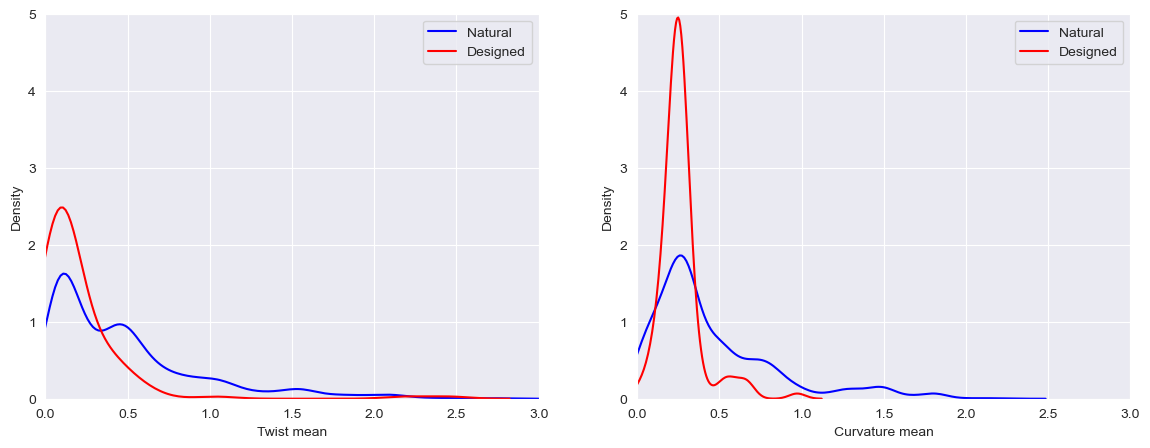

In [89]:
# KDE distribution mean of twist and curvature for natural and designed proteins

# Set the same limits for both axes across both plots
x_lim = (0, 3.0)  
y_lim = (0, 5.0)

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Twist mean comparison
# squeeze() is used for enabling "color" parameter
# https://stackoverflow.com/questions/68096271/how-to-color-different-seaborn-kdeplots-in-one-figure
sns.kdeplot(df.loc[(df['class'].str.startswith('3', '4')) & (df['designed'].isnull()), ['twist_mean']].squeeze(), label='Natural', color='blue', ax=axes[0])
sns.kdeplot(df.loc[(df['class'].str.startswith('3', '4')) & (df['designed']==True), ['twist_mean']].squeeze(), label='Designed', color='red', ax=axes[0])

axes[0].set_xlabel('Twist mean')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].set_xlim(x_lim)
axes[0].set_ylim(y_lim)

# Curvature mean comparison
sns.kdeplot(df.loc[(df['class'].str.startswith('3', '4')) & (df['designed'].isnull()), ['curvature_mean']].squeeze(), label='Natural', color='blue', ax=axes[1])
sns.kdeplot(df.loc[(df['class'].str.startswith('3', '4')) & (df['designed']==True), ['curvature_mean']].squeeze(), label='Designed', color='red', ax=axes[1])
axes[1].set_xlabel('Curvature mean')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].set_xlim(x_lim)
axes[1].set_ylim(y_lim)

# Adjust layout
# plt.tight_layout()
# plt.show
plt.savefig("data/figures/natural_design.png", bbox_inches='tight')


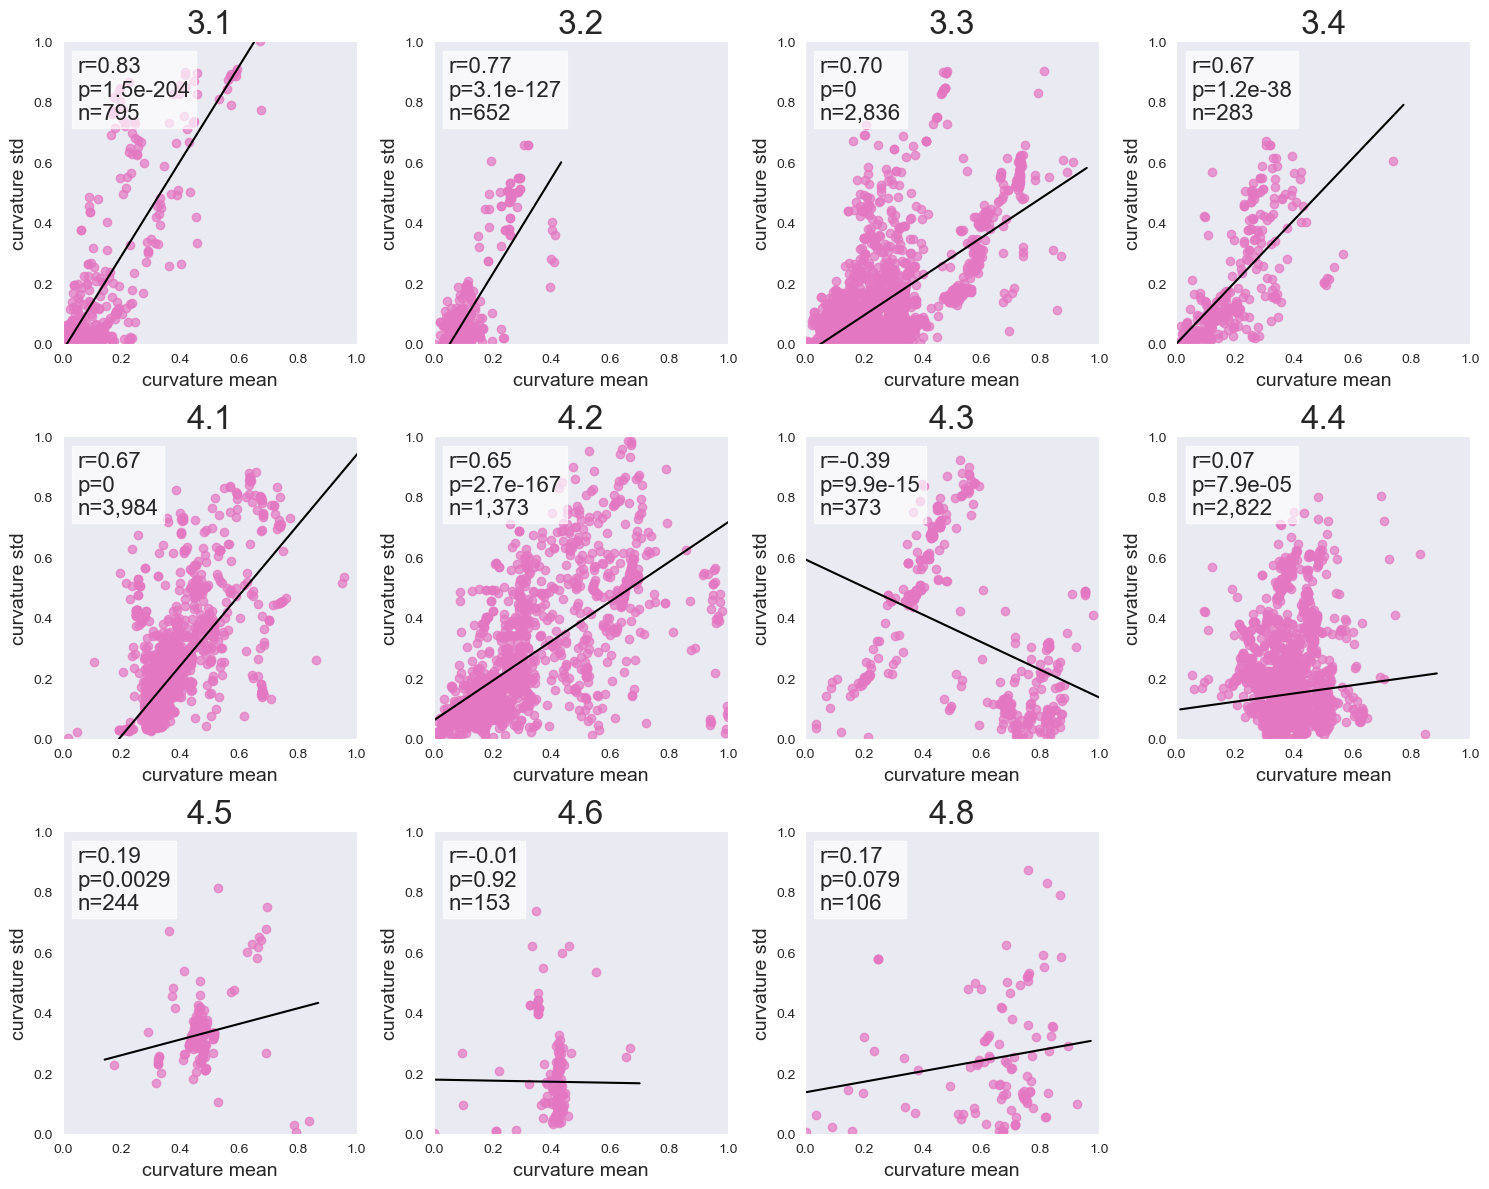

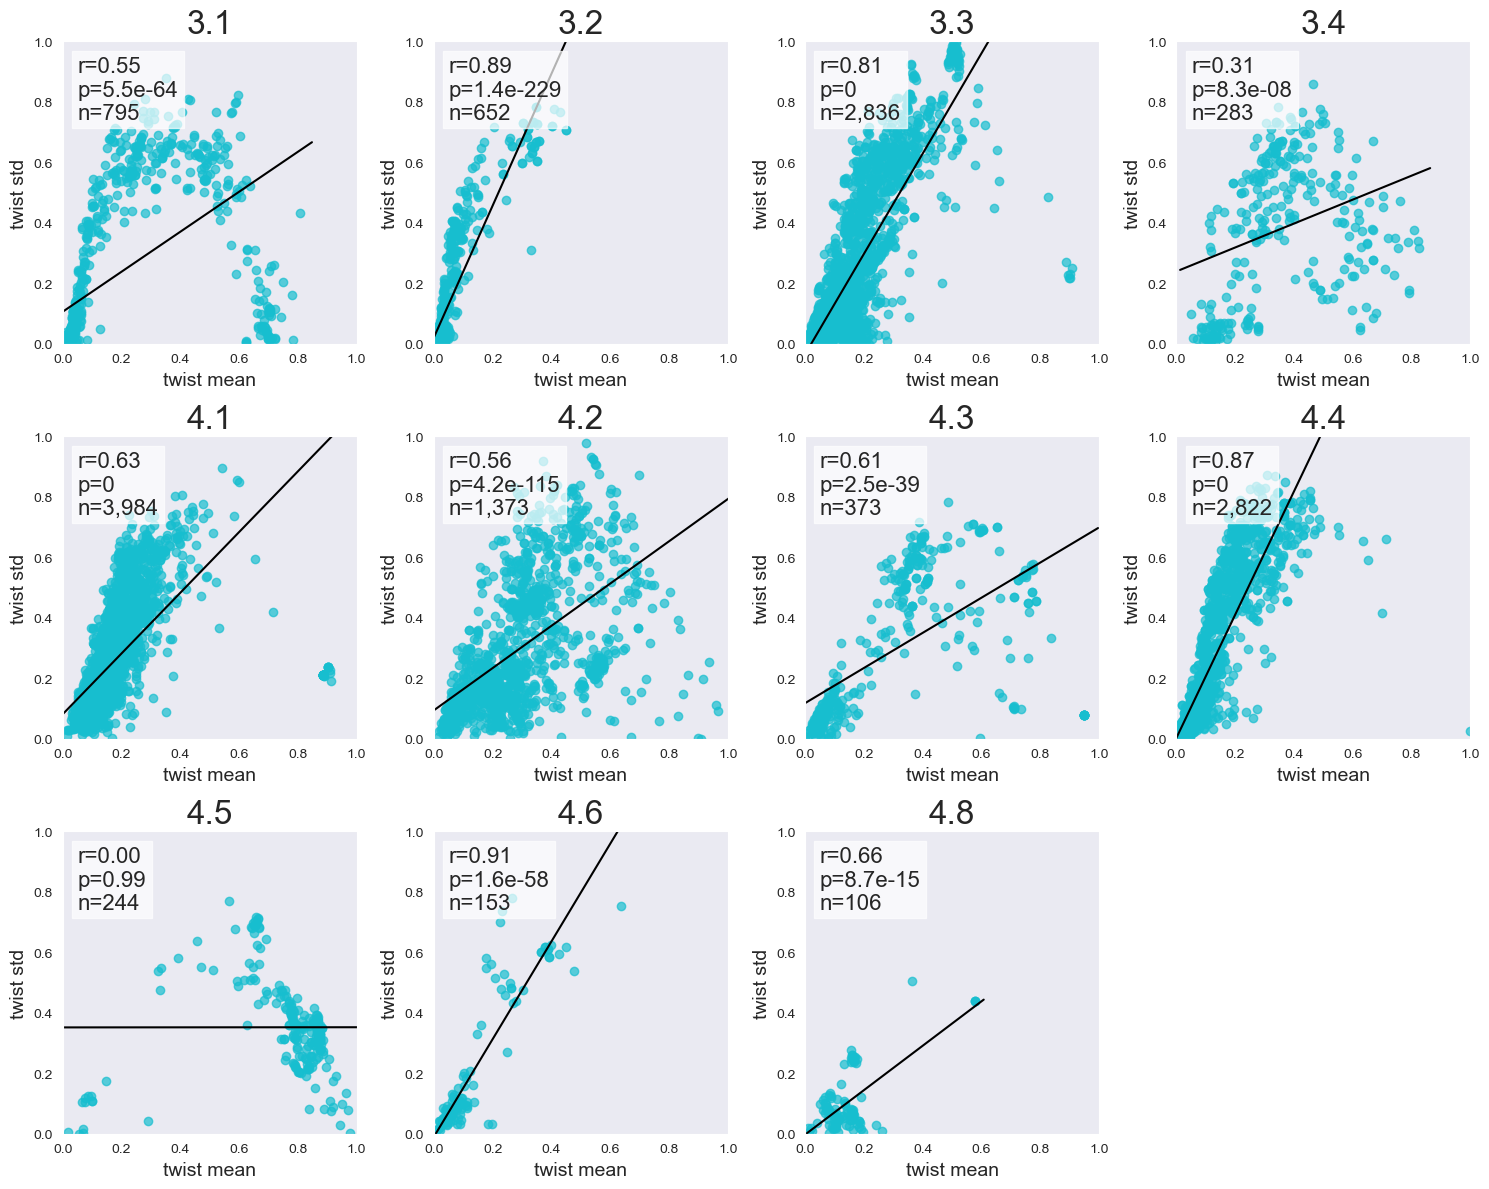

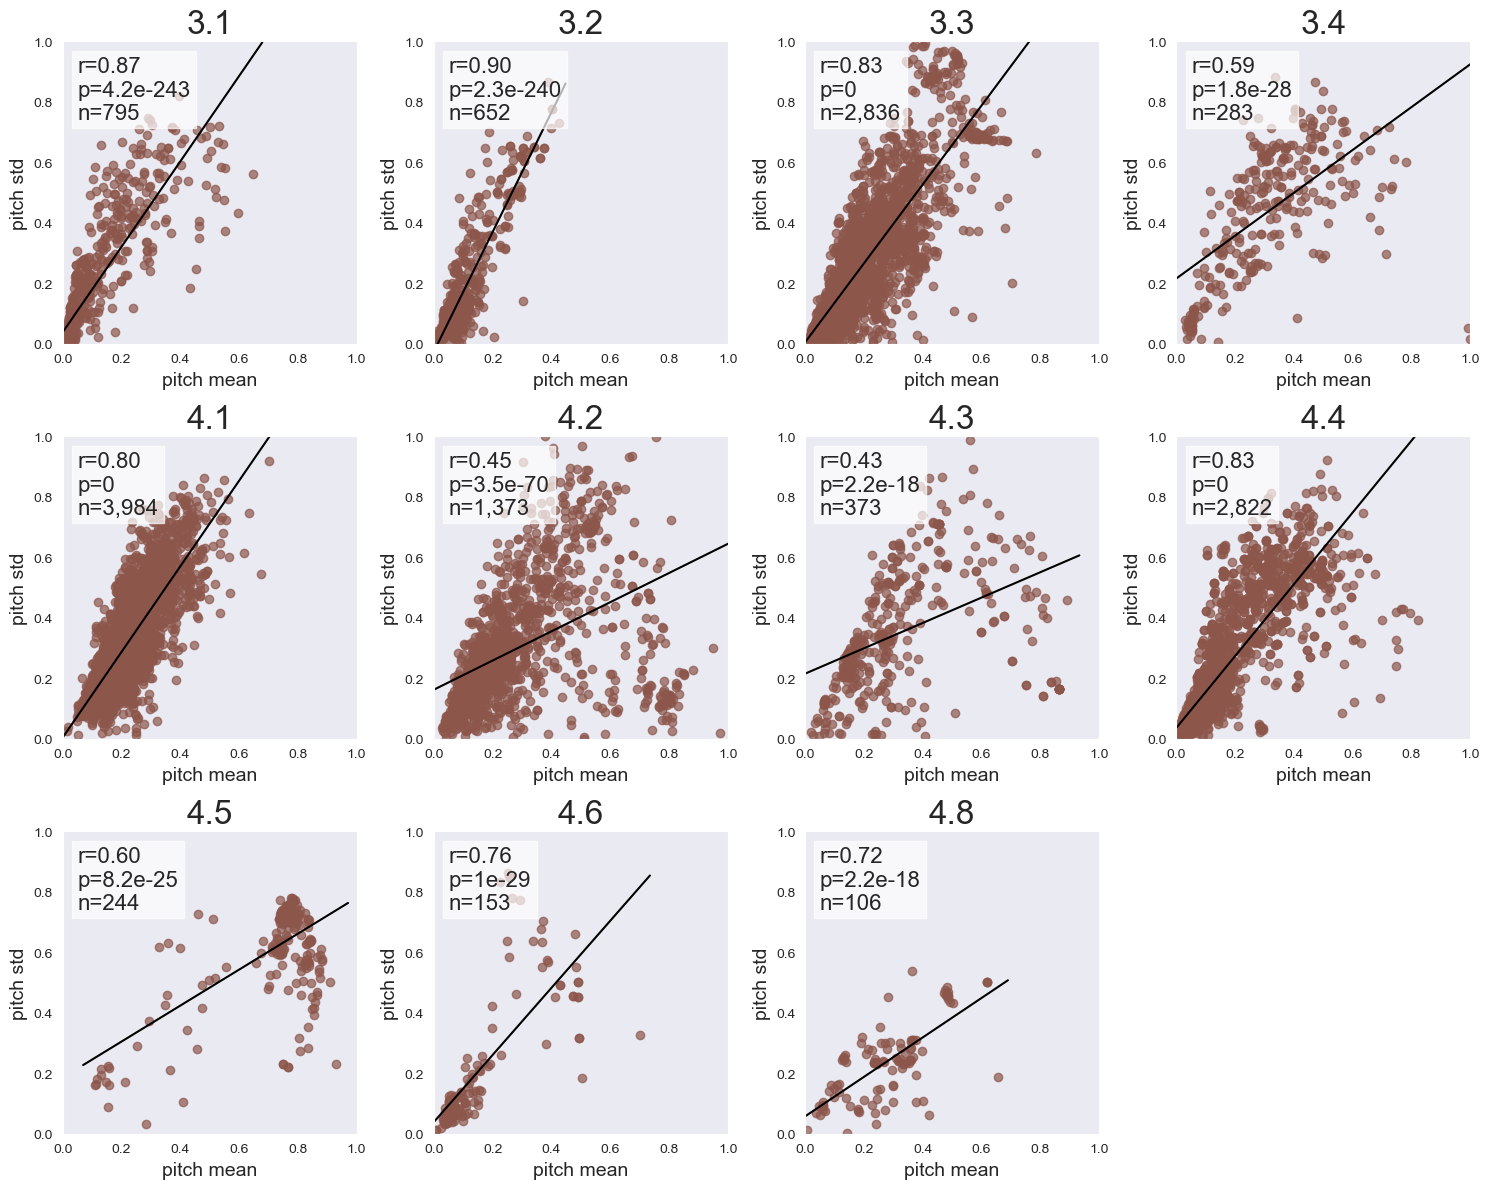

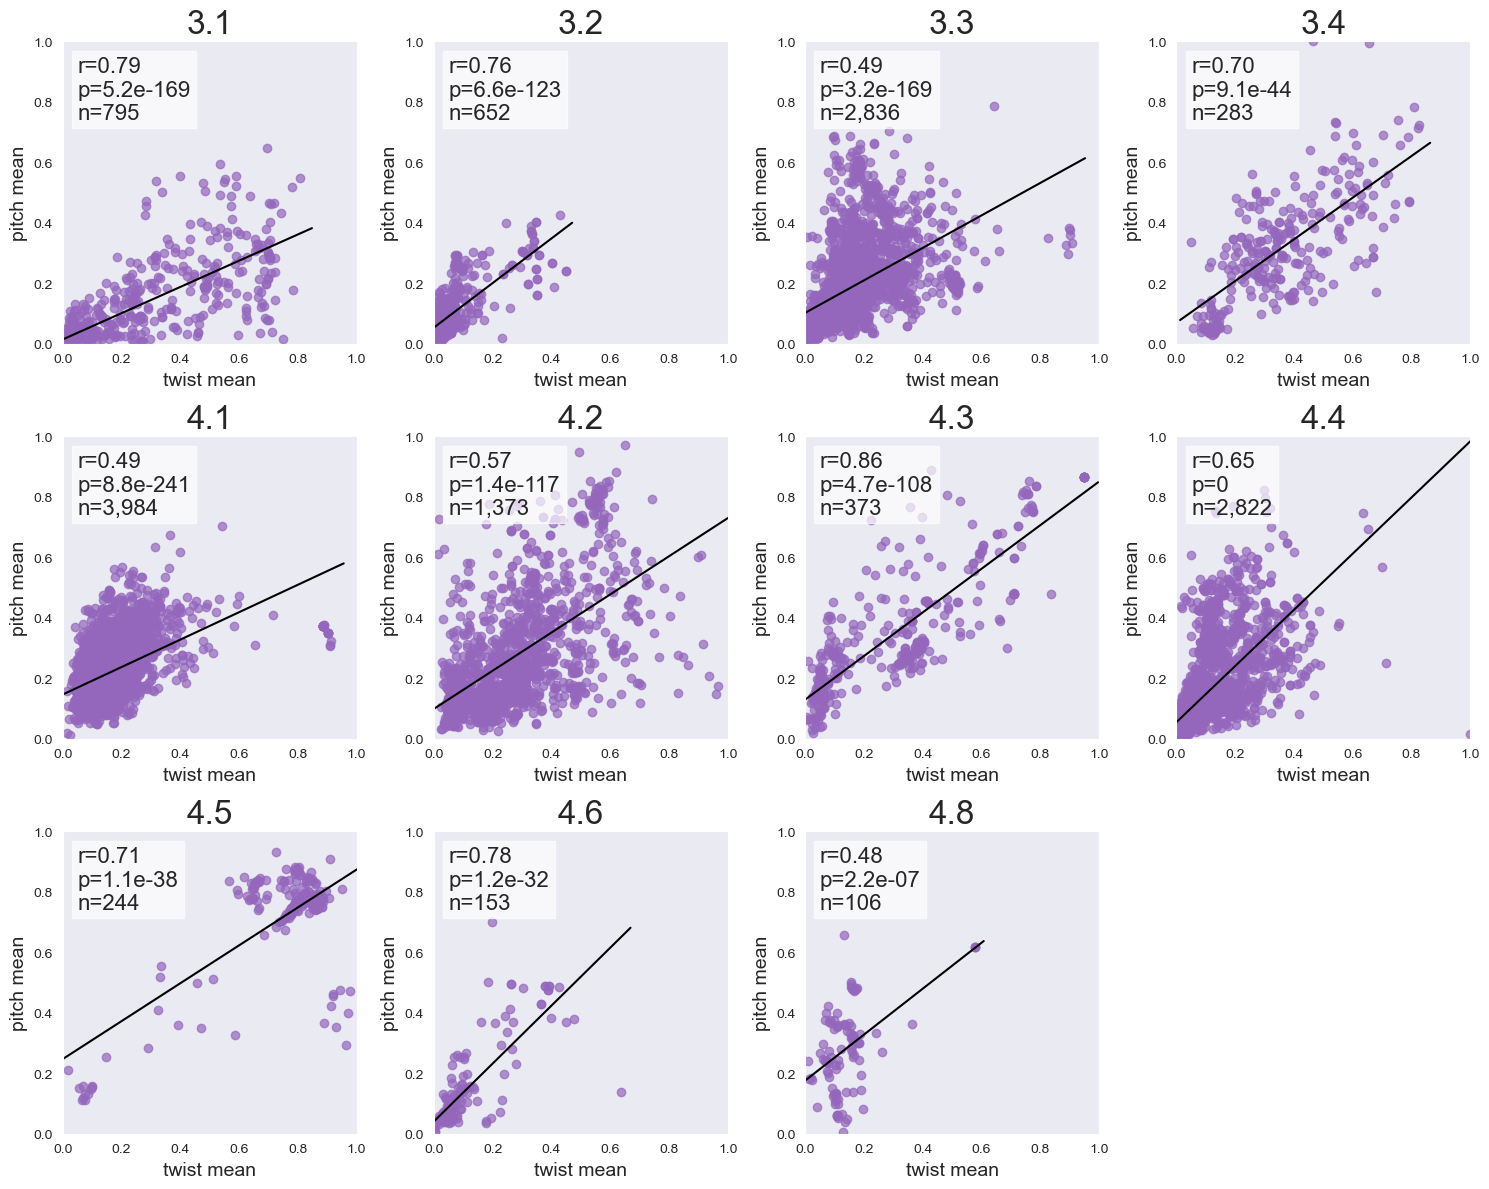

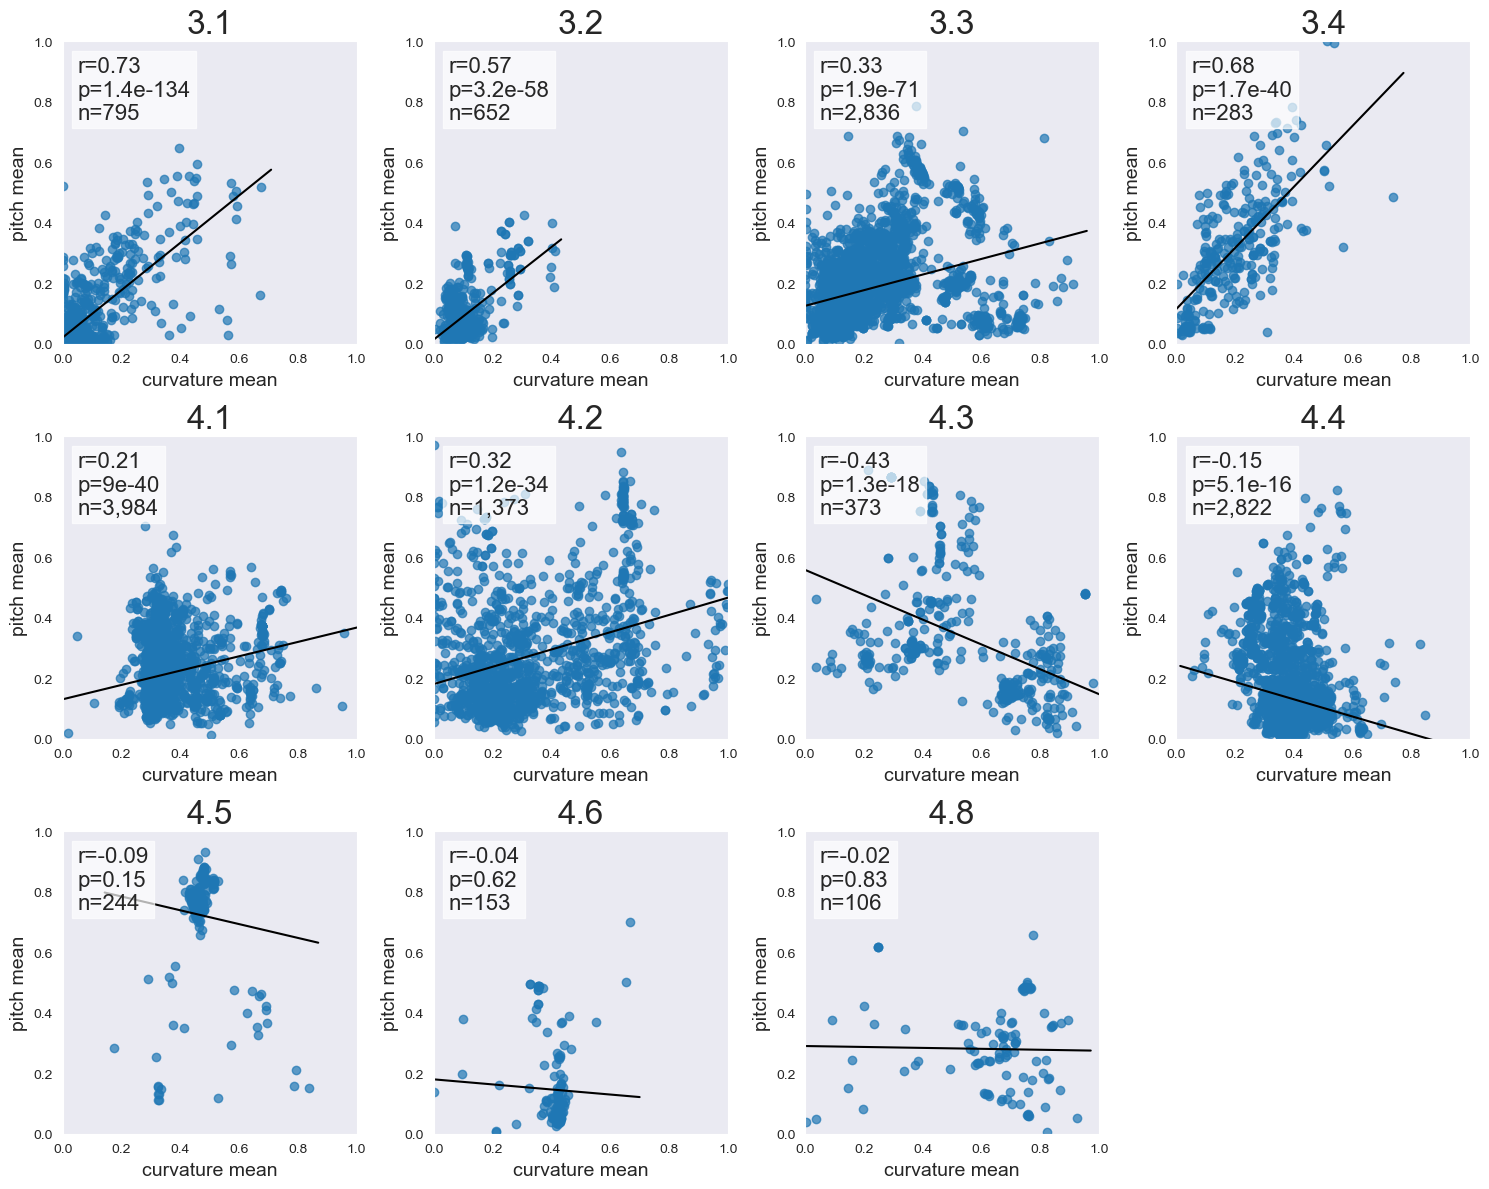

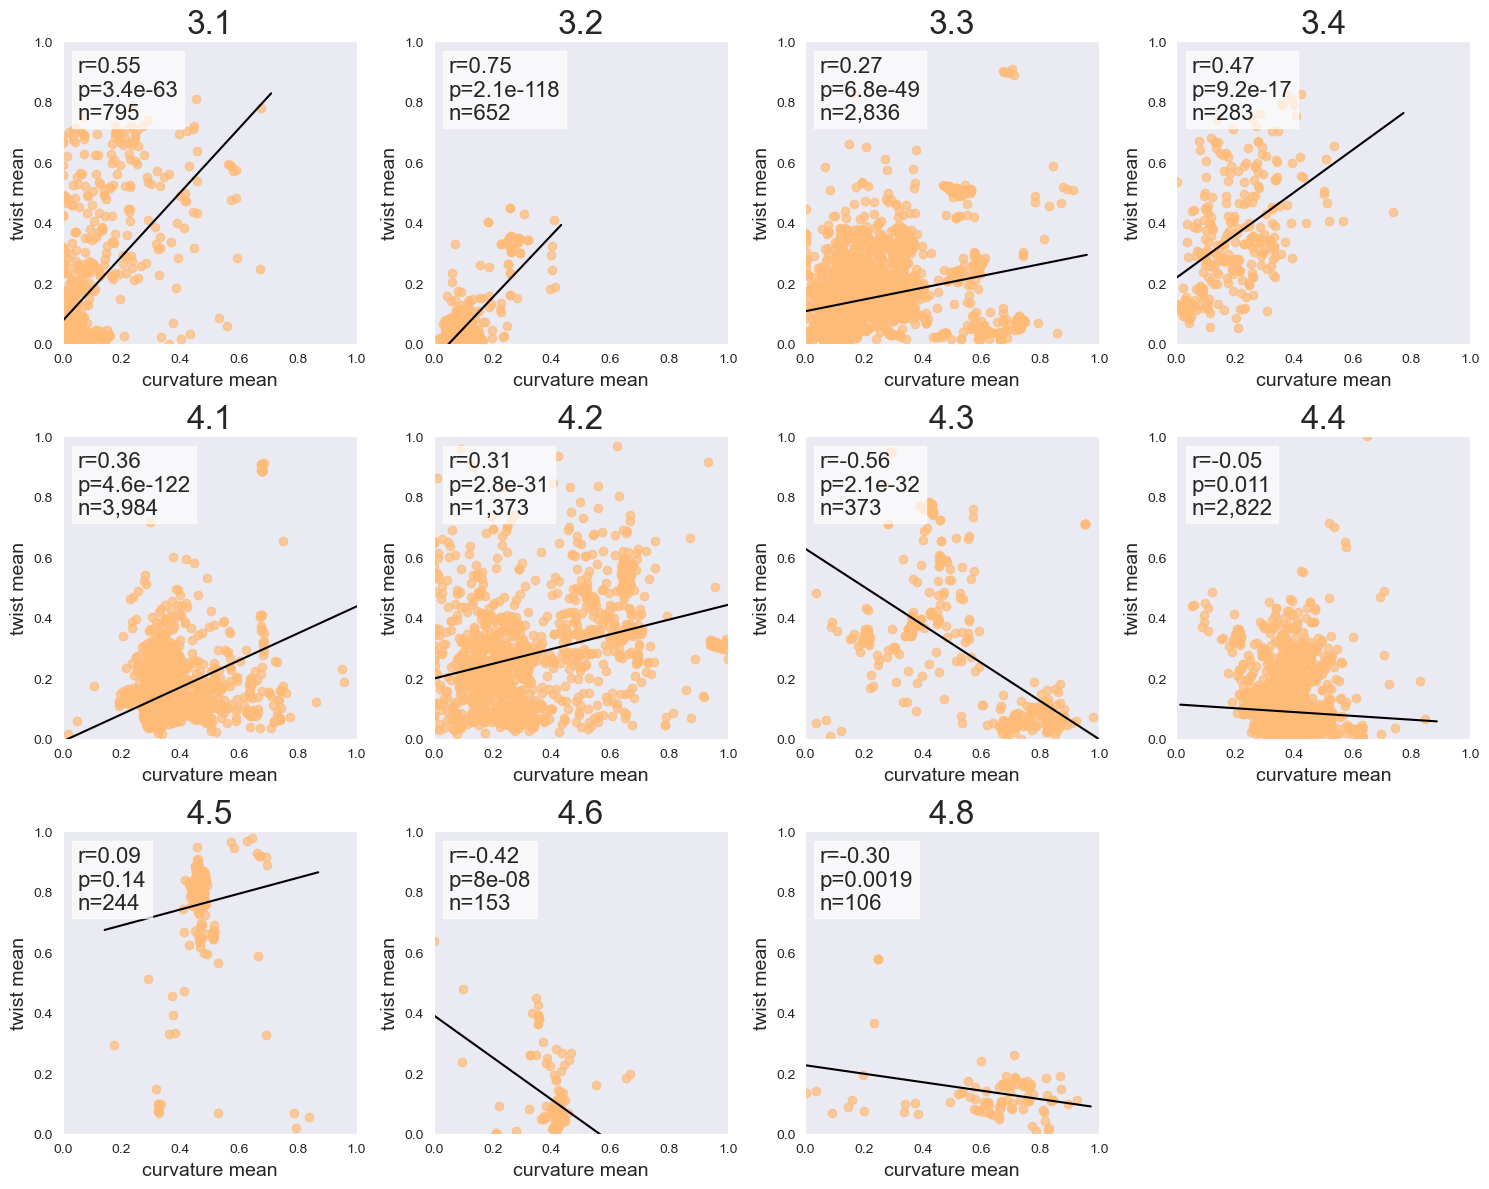

In [90]:
# Correlation figures

x_vals = ['curvature_mean', 'twist_mean', 'pitch_mean', 'twist_mean', 'curvature_mean', 'curvature_mean']
y_vals = ['curvature_std', 'twist_std', 'pitch_std', 'pitch_mean', 'pitch_mean', 'twist_mean',]
colors = ['#e377c2', '#17becf', '#8c564b', '#9467bd', '#1f77b4', '#ffbb78']

for x_val, y_val, color in zip(x_vals, y_vals, colors):

    # Drop rows with NaN values in 'curv_mean' or 'curv_std'
    df_ = df.dropna(subset=[x_val, y_val])

    # Filter out rows where 'classification' is NaN, '2.1', or '2.2'
    df_ = df_[~df_['class'].isin(['nan', '2.1', '2.2','4.7'])]
    df_ = df_[~df_['class'].str.startswith('5')]

    # Extract the first two components of the classification value (e.g., "3.3" from "3.3.1.4")
    df_['classification_group'] = df_['class'].apply(lambda x: '.'.join(x.split('.')[:2]))

    # Filter rows where 'classification_group' equals '3.1'
    # filtered_df = df_[df_['classification_group'] == '4.8']
    # print(filtered_df)

    # Calculate global min and max for normalization
    min_mean = df_[x_val].min()
    max_mean = df_[x_val].max()
    min_std = df_[y_val].min()
    max_std = df_[y_val].max()

    # Normalize interested columns
    df_[x_val] = (df_[x_val] - min_mean) / (max_mean - min_mean)
    df_[y_val] = (df_[y_val] - min_std) / (max_std - min_std)

    # Group by the classification
    groups = df_.groupby('classification_group')

    # Determine the number of subplots needed
    num_groups = len(groups)
    cols = 4  # Number of columns in the grid
    rows = (num_groups + cols - 1) // cols  # Calculate rows based on the number of groups and columns

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()  # Flatten to easily index each subplot

    # Plot each group in a separate subplot
    for i, (name, group) in enumerate(groups):

        axes[i].scatter(group[x_val], group[y_val], alpha=0.7, color=color)

        # Calculate and plot linear regression line
        slope, intercept, r_value, p_value, std_err = stats.linregress(group[x_val], group[y_val])
        x_vals = np.array(axes[i].get_xlim())
        y_vals = intercept + slope * x_vals
        #axes[i].plot(x_vals, y_vals, color='black', linewidth=1.5, label=f'ρ = {r_value:.2f}')
        axes[i].plot(x_vals, y_vals, color='black', linewidth=1.5, label=f' p ={p_value:.3g}')

        # Add correlation coefficient (Pearson's r) to the plot
        axes[i].text(0.05, 0.95, "r={:.2f}\np={:.2g}\nn={:,}".format(r_value, p_value, group.shape[0]), transform=axes[i].transAxes, fontsize=16, verticalalignment='top',
                     bbox=dict(facecolor='white', alpha=0.7))

        axes[i].set_title(f'{name}', fontsize=24)
        axes[i].set_xlabel(x_val.replace('_', ' '), fontsize=14)
        axes[i].set_ylabel(y_val.replace('_', ' '), fontsize=14)
        axes[i].grid(False)
        axes[i].set_xlim(0, 1.0)
        axes[i].set_ylim(0, 1.0)

    # Remove any empty subplots if the number of groups does not perfectly fill the grid
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    # Show the figure
    # plt.show()
    plt.savefig("data/figures/corr_{}_{}.png".format(x_val.split('_')[0], y_val.split('_')[0]), bbox_inches='tight')


designed
natural


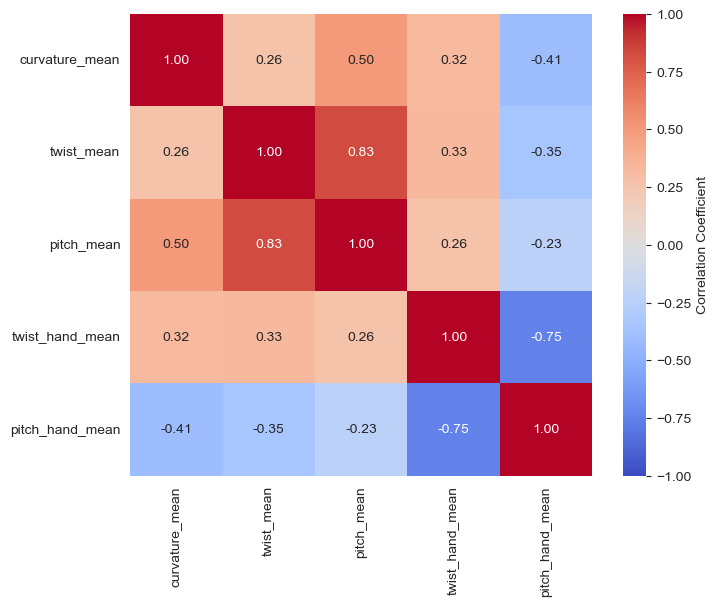

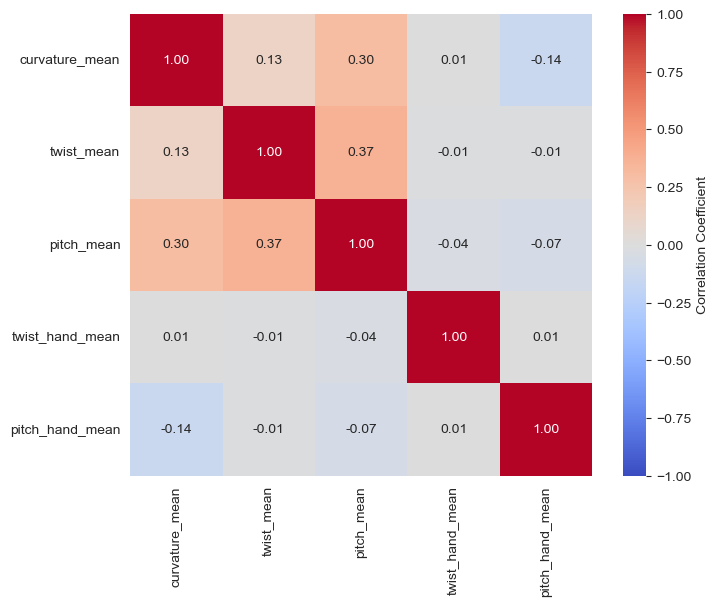

In [91]:
# Heatmap Pearson correlation of geometry parameters for natural and designed proteins

# Relevant columns
columns = ['curvature_mean', 'twist_mean', 'pitch_mean', 'twist_hand_mean', 'pitch_hand_mean']

for dataset in ['designed', 'natural']:
    print(dataset)

    # Drop rows with NaN values in the columns of interest
    if dataset == 'designed':
        df_ = df.loc[df['designed']==True].dropna(subset=columns)
    else:
        df_ = df.loc[df['designed'].isnull()].dropna(subset=columns)

    # Calculate the correlation matrix
    correlation_matrix = df_[columns].corr()

    # Create a heatmap of the correlation matrix with annotations
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1,
                cbar_kws={'label': 'Correlation Coefficient'}, square=True)

    # Show the plot
    plt.savefig("data/figures/corr_parameters_{}.png".format(dataset), bbox_inches='tight')

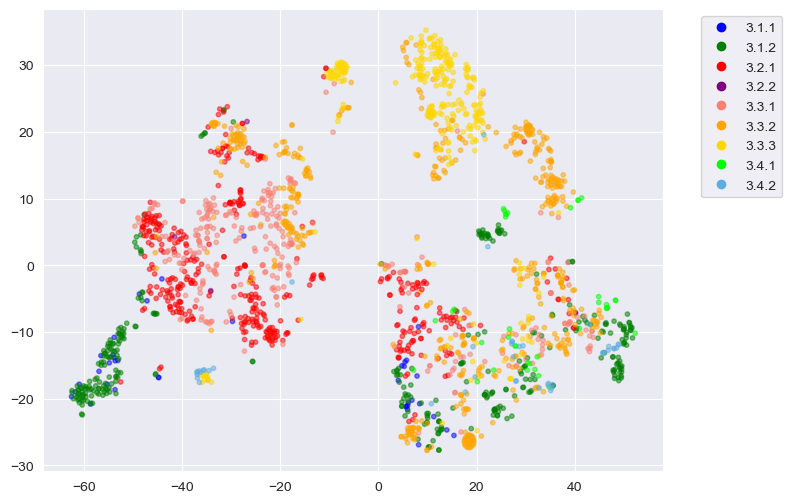

In [92]:
# Main figure D t-SNE plot
custom_colors = {
    '3.1.1': '#0000FF',  # Blue
    '3.1.2': '#008000',  # Green
    '3.2.1': '#FF0000',  # Red
    '3.2.2': '#800080',  # Purple
    '3.3.1': '#FA8072',  # Salmon
    '3.3.2': '#FFA500',  # Orange
    '3.3.3': '#FFD700',  # Yellow
    '3.4.1': '#00FF00',  # Bright Green
    '3.4.2': '#5DADE2',  # Sky Blue
}
numerical_columns = [
    "curvature_mean", "curvature_std", "twist_mean", "twist_std",
    "pitch_mean", "pitch_std"
]

# Create unique ID and extract fold-level category (e.g., "3.1.1" from "3.1.1.4")
df_ = df.copy()
df_['id'] = df_['pdb_id'] + '_' + df_['chain']
df_['CTFC_category'] = df_['class'].str.split('.').str[:3].str.join('.')
df_ = df_[df_['CTFC_category'].isin(custom_colors.keys())]

numerical_data = df_[numerical_columns]
scaler = StandardScaler()
normalized_data = scaler.fit_transform(numerical_data)

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, n_iter=3000, random_state=40)
tsne_result = tsne.fit_transform(normalized_data)

# Prepare colors and output DataFrame
point_colors = df_['CTFC_category'].map(custom_colors)
tsne_df = pd.DataFrame(tsne_result, columns=['Component 1', 'Component 2'])
tsne_df['id'] = df_['id'].values
tsne_df['CTFC_category'] = df_['CTFC_category'].values

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=point_colors, s=10, alpha=0.5)

# Add legend
handles = [
    plt.Line2D([0], [0], marker='o', color=color, linestyle='', label=label)
    for label, color in custom_colors.items() if label in df_['CTFC_category'].unique()
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("data/figures/tsne.png".format(dataset), bbox_inches='tight')


/tmp/ipykernel_46687/1024686696.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['classification_group'] = df_['class'].apply(lambda x: '.'.join(x.split('.')[:2]))
/tmp/ipykernel_46687/1024686696.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['classification_group'] = df_['class'].apply(lambda x: '.'.join(x.split('.')[:2]))


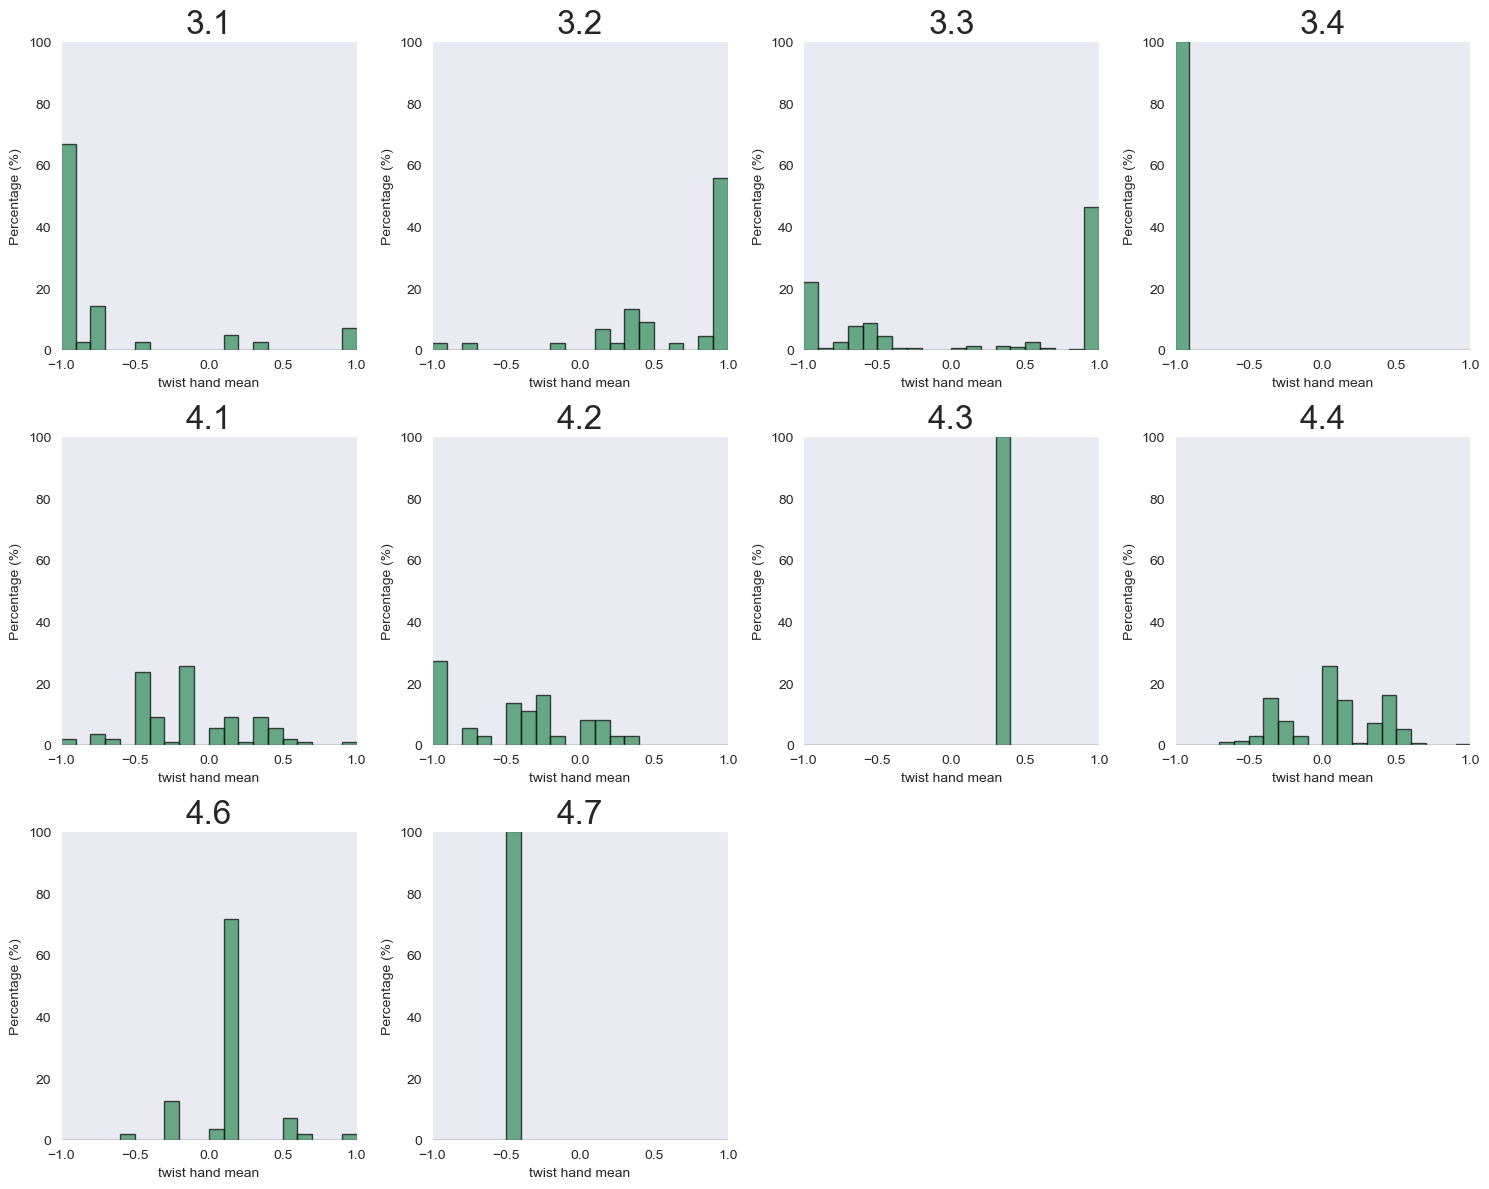

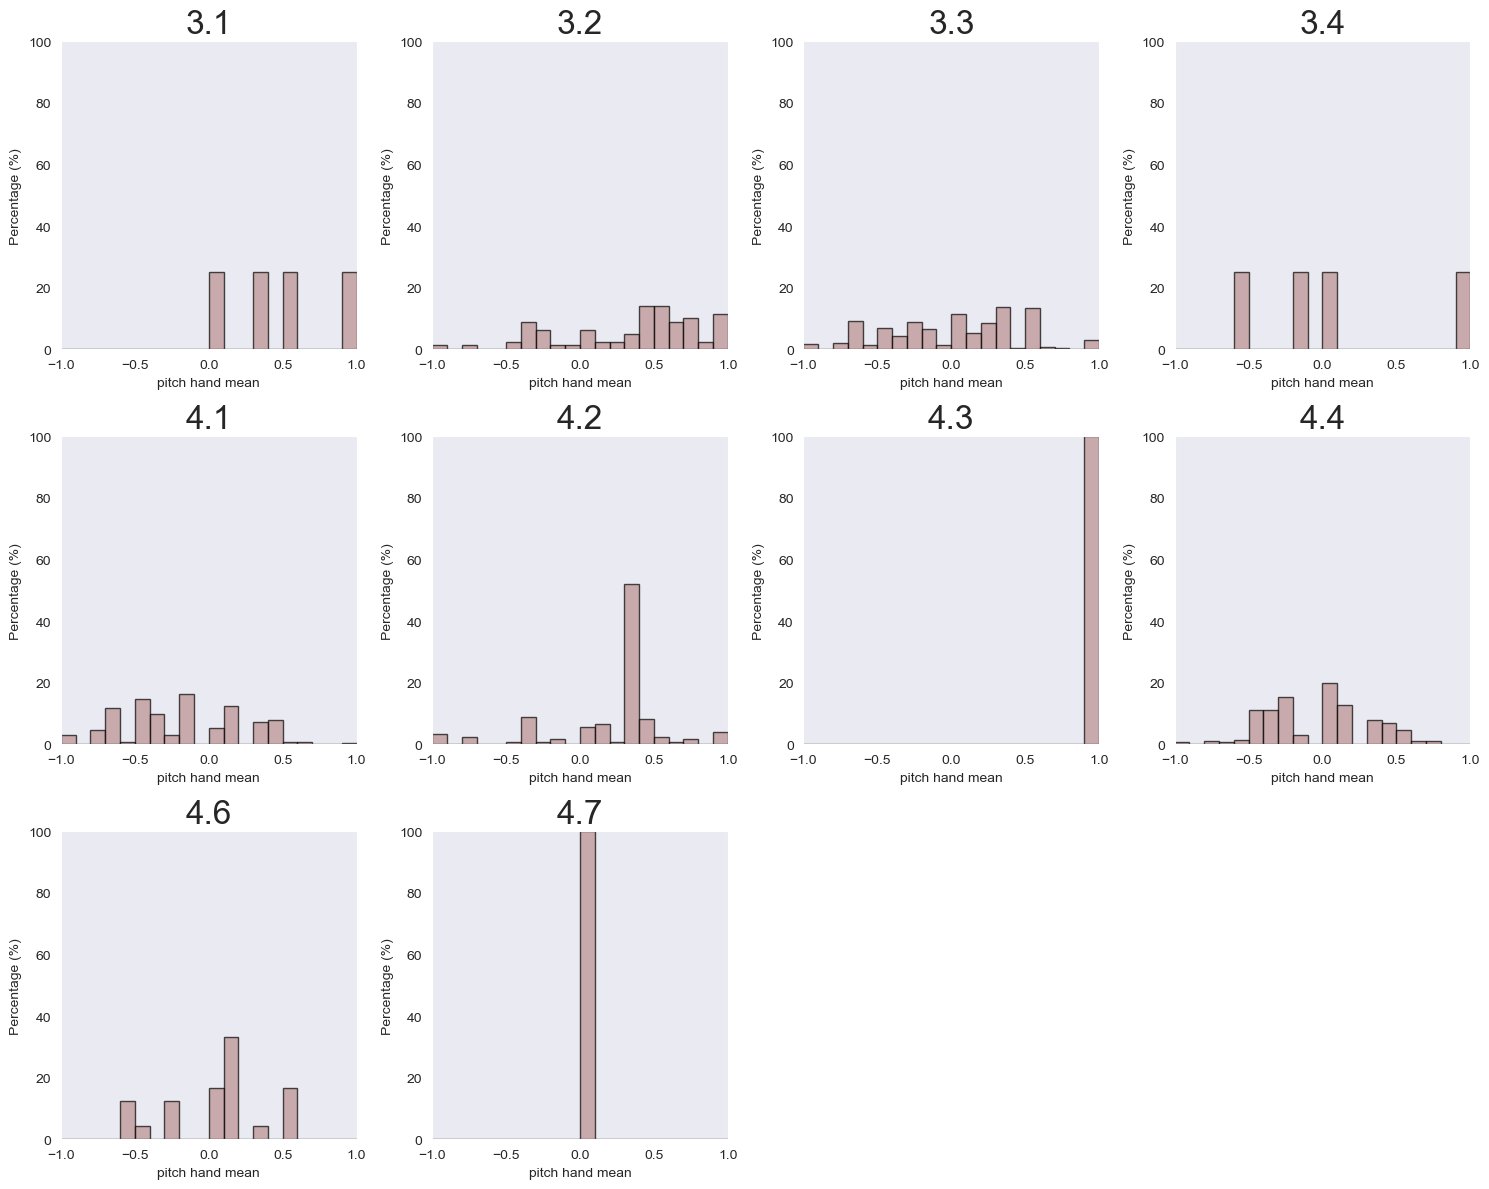

In [93]:
# Twist and pitch handedness in Class 3 and Class 4 with repeat unit number >=6

for col_hand, col_mean, col_std, color in [['twist_hand_mean', 'twist_mean', 'twist_std', '#2E8B57'],
                                           ['pitch_hand_mean', 'pitch_mean', 'pitch_std', '#BC8F8F']]:

    # Drop NaN values
    df_ = df.dropna(subset=[col_hand, col_mean, col_std])

    # Filter for classes starting with "3" or "4"
    df_ = df[df['class'].str.startswith(('3', '4'))]
    df_['classification_group'] = df_['class'].apply(lambda x: '.'.join(x.split('.')[:2]))

    # Group by topology
    groups = df_.groupby('classification_group')

    # Apply filtering to each group based on conditions
    filtered_groups = []
    for name, group in groups:
        # Filter the group based on twist/pitch_mean > 0.1 and twist/pitch_std < 0.1
        filtered_group = group[(group[col_mean] > 0.1) & (group[col_std] < 0.1) & (group['unit_count'] > 5)]
        #print(filtered_group)
        if not filtered_group.empty:
            filtered_groups.append(filtered_group)

    # Combine filtered groups
    filtered_strps_df = pd.concat(filtered_groups)

    # Group the filtered DataFrame
    filtered_groups = filtered_strps_df.groupby('classification_group')

    # Set number of plots
    num_groups = len(filtered_groups)
    cols = 4
    rows = (num_groups + cols - 1) // cols

    # Create figure
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()

    # Define fixed bins with edge alignment
    shared_bins = np.linspace(-1, 1, 21)  # 20 bins of width 0.1

    # Plot each histogram
    for i, (name, group) in enumerate(filtered_groups):
        total_regions = len(group)

        # Force histogram to use full range
        counts, bin_edges = np.histogram(
            group[col_hand],
            bins=shared_bins,
            range=(-1, 1)  # Explicit range enforcement
        )

        # Convert to percentage with zero-division handling
        percentages = (counts / total_regions) * 100 if total_regions != 0 else np.zeros_like(counts)

        # Plot with edge alignment
        axes[i].bar(
            bin_edges[:-1],
            percentages,
            width=np.diff(bin_edges),
            color=color,
            alpha=0.7,
            edgecolor='black',
            align='edge'
        )

        # Plot histogram using calculated percentages

        # Consistent formatting
        axes[i].set_title(f'{name}', fontsize=24)
        axes[i].set_xlabel(col_hand.replace('_', ' '), fontsize=10)
        axes[i].set_ylabel('Percentage (%)', fontsize=10)
        axes[i].set_ylim(0, 100)
        axes[i].set_xlim(-1, 1)  # Match bin range
        axes[i].grid(False)

    # Remove extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()

    # Show the figure
    plt.savefig("data/figures/dist_hand_{}.png".format(col_hand.split("_")[0]), bbox_inches='tight')


Classification 3.1: 795 rows
Classification 3.2: 652 rows
Classification 3.3: 2836 rows
Classification 3.4: 283 rows
Classification 4.1: 3984 rows
Classification 4.2: 1373 rows
Classification 4.3: 373 rows
Classification 4.4: 2822 rows
Classification 4.5: 244 rows
Classification 4.6: 153 rows
Classification 4.8: 106 rows
Classification 3.1: 795 rows
Classification 3.2: 652 rows
Classification 3.3: 2836 rows
Classification 3.4: 283 rows
Classification 4.1: 3984 rows
Classification 4.2: 1373 rows
Classification 4.3: 373 rows
Classification 4.4: 2822 rows
Classification 4.5: 244 rows
Classification 4.6: 153 rows
Classification 4.8: 106 rows
Classification 3.1: 795 rows
Classification 3.2: 652 rows
Classification 3.3: 2836 rows
Classification 3.4: 283 rows
Classification 4.1: 3984 rows
Classification 4.2: 1373 rows
Classification 4.3: 373 rows
Classification 4.4: 2822 rows
Classification 4.5: 244 rows
Classification 4.6: 153 rows
Classification 4.8: 106 rows


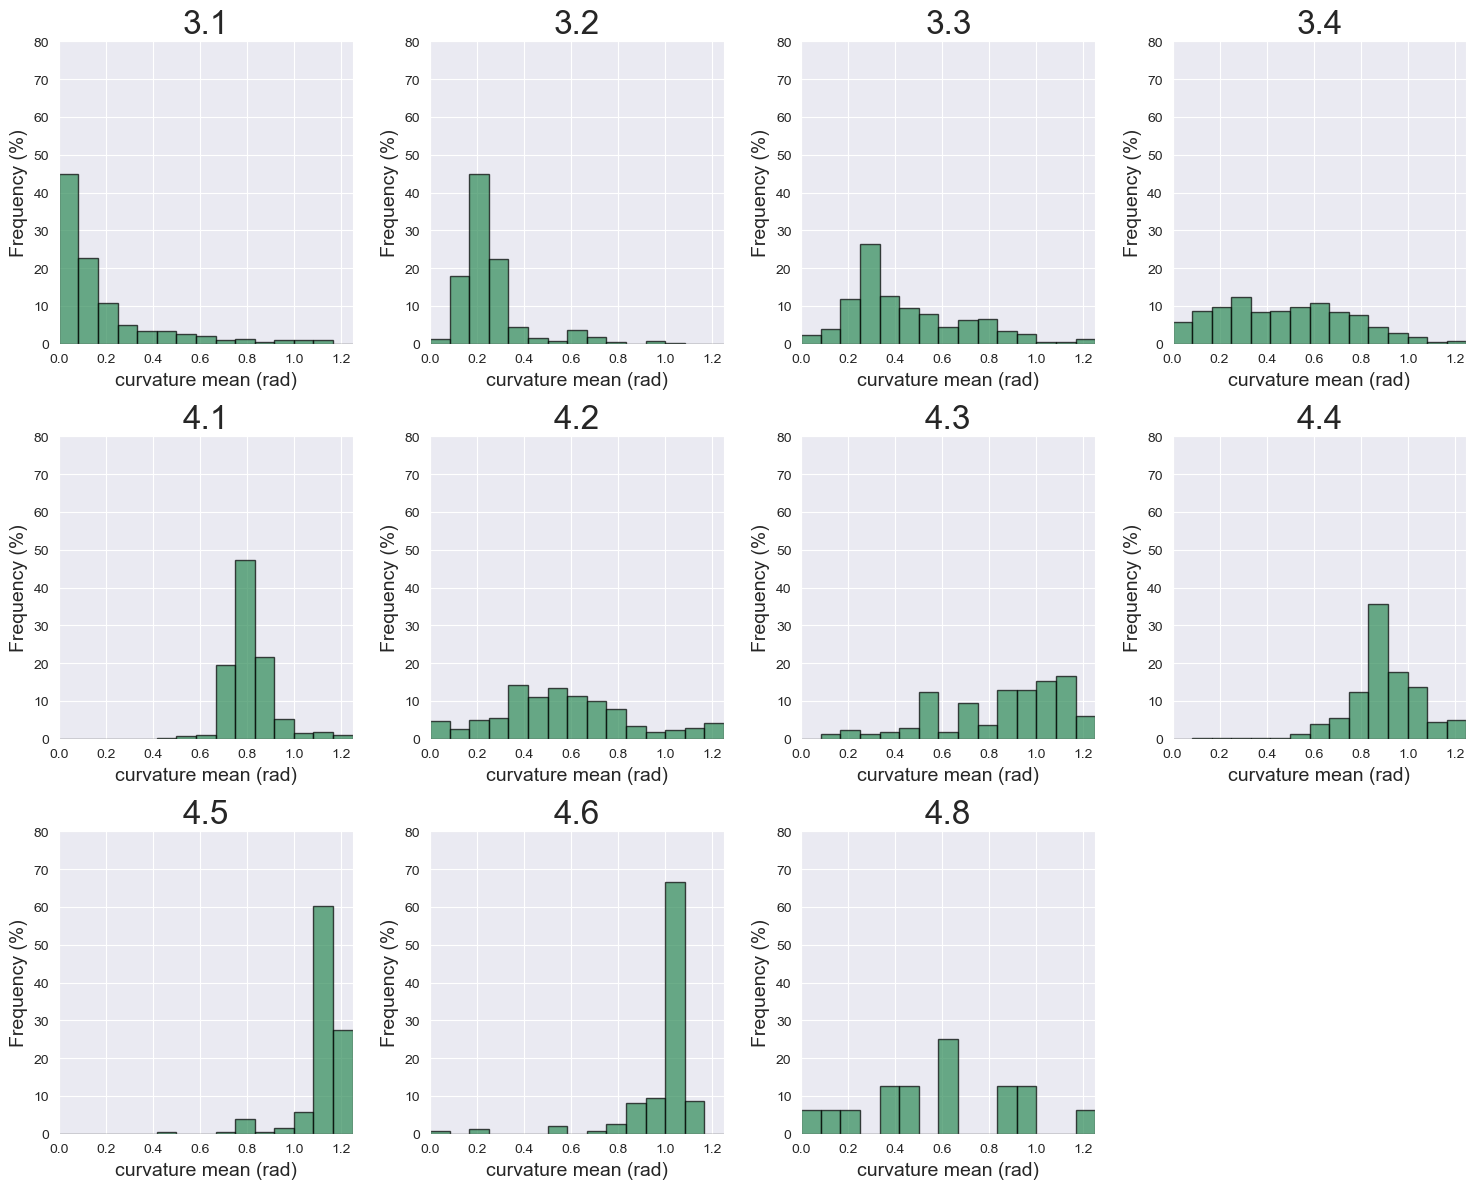

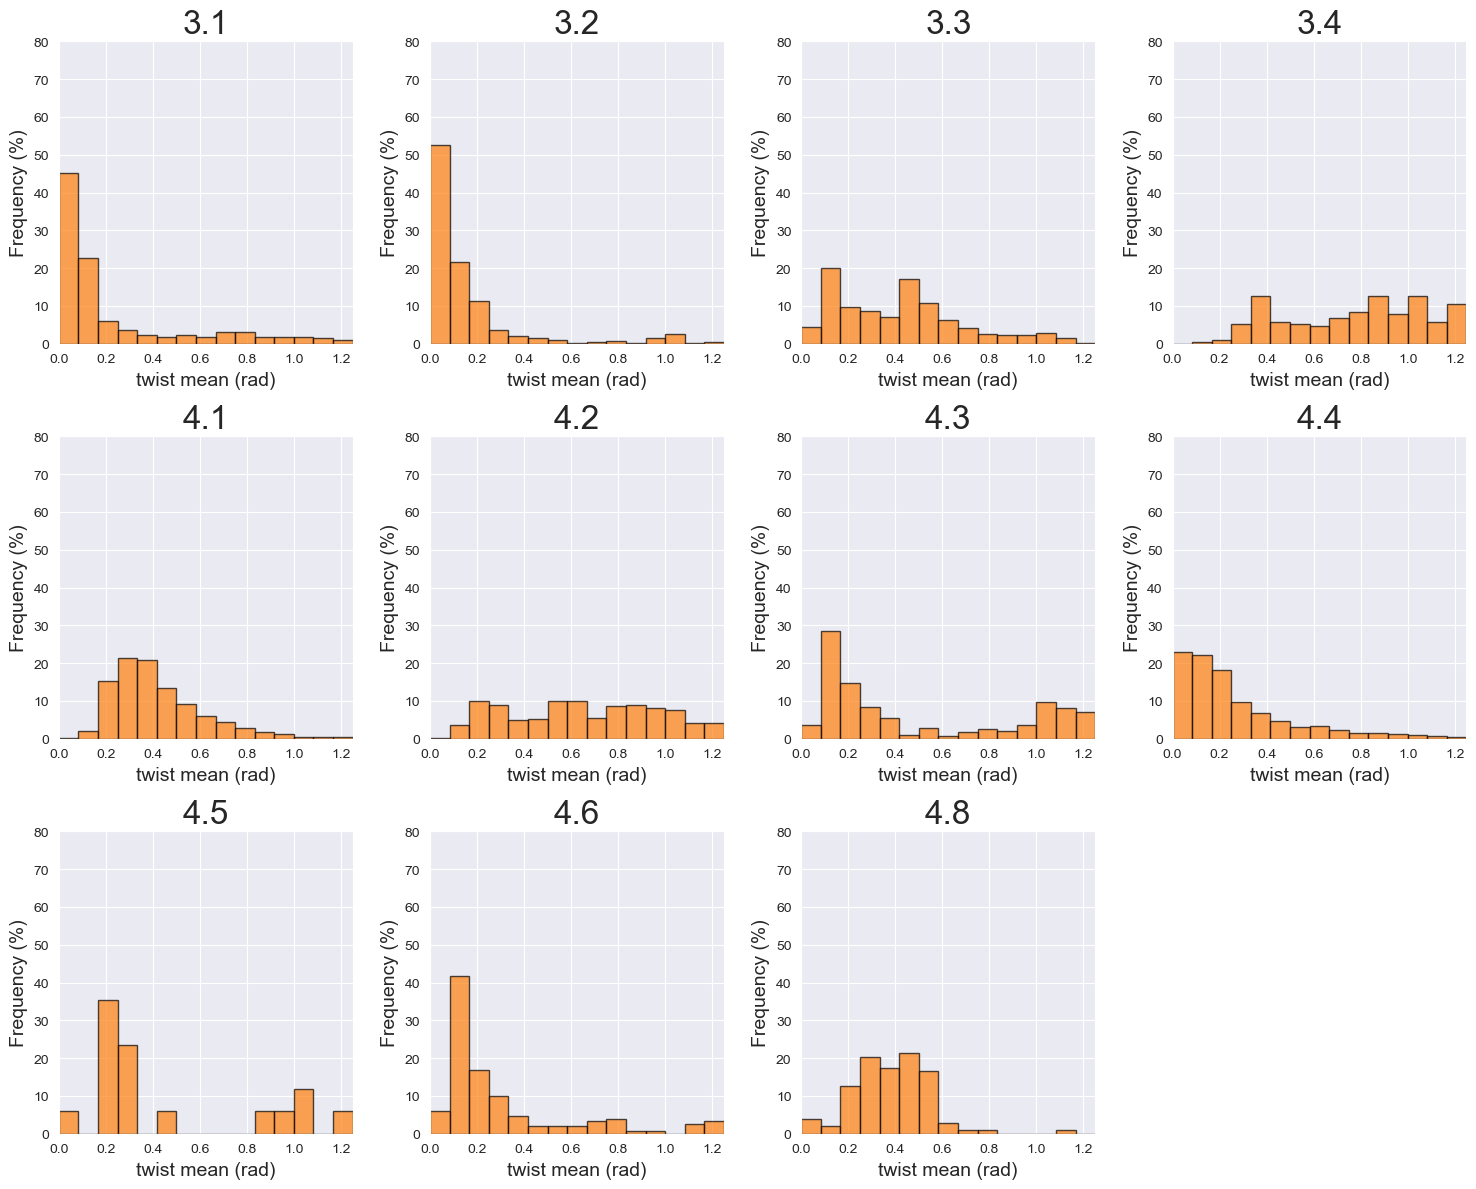

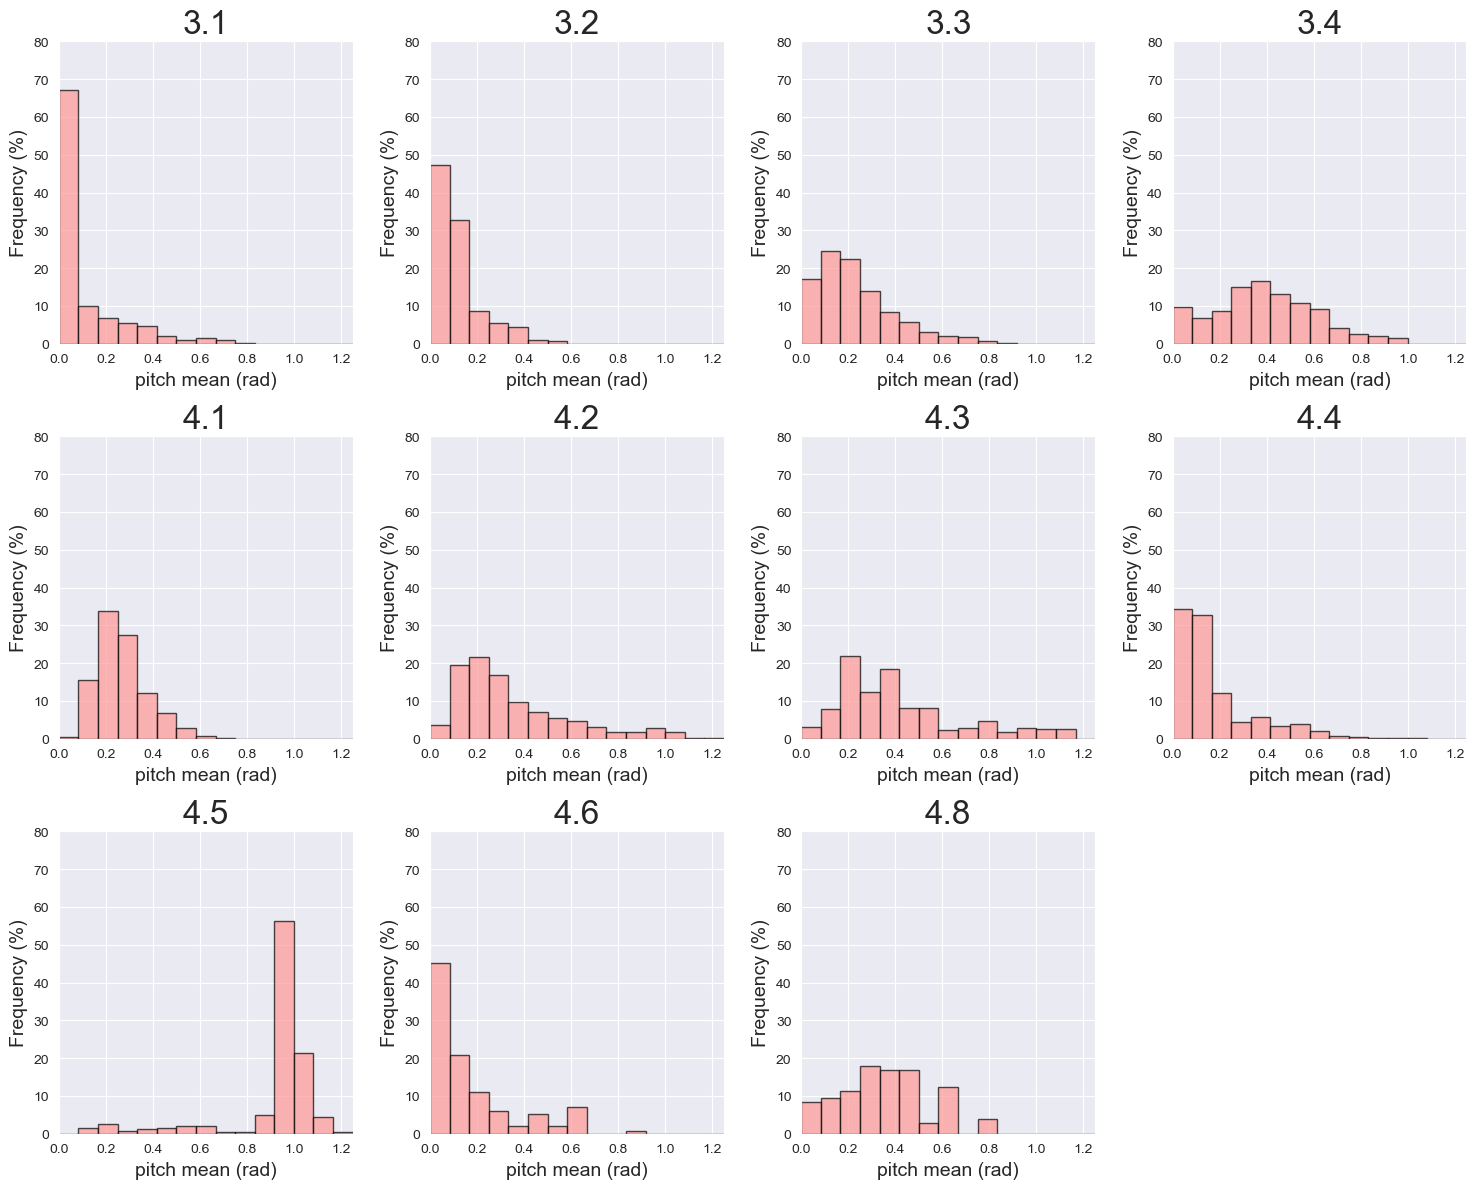

In [94]:
# Parameters distribution
#
#
# # Load the natural proteins data
# strps_input = "../data/geometre_annotated_output.csv"
# strps_df = pd.read_csv(strps_input)
#
# # Clean and preprocess data
# strps_df.columns = strps_df.columns.str.strip()
# strps_df['curvature_mean'] = pd.to_numeric(strps_df['curvature_mean'], errors='coerce')
# strps_df['classification'] = strps_df['classification'].astype(str)

 # Fig S1 color='#2E8B57'
        # Fig S2 color='#ff7f0e'
        # Fig S3 color='#ff9896'

for col_mean, color in [['curvature_mean', '#2E8B57'], ['twist_mean', '#ff7f0e'], ['pitch_mean', '#ff9896']]:

    df_ = df.dropna(subset=[col_mean])

    # Filter classifications
    df_ = df_[~df_['class'].isin(['nan', '2.1', '2.2','4.7'])]
    df_ = df_[~df_['class'].str.startswith('5')]

    # Create classification groups
    df_['classification_group'] = df_['class'].apply(lambda x: '.'.join(x.split('.')[:2]))
    #filtered_df = df_[df_['classification_group'] == '4.8']

    # Group data
    groups = df_.groupby('classification_group')

    # Define plot grid
    num_groups = len(groups)
    cols = 4
    rows = (num_groups + cols - 1) // cols

    # Create figure and axes
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
    axes = axes.flatten()

    shared_bins = np.linspace(0, 1.25, 16)  # 15 bins (0-1.25)

    for i, (name, group) in enumerate(groups):
        print(f'Classification {name}: {len(group)} rows')
        # Force histogram to use full range
        counts, bin_edges = np.histogram(
            group[col_mean],
            bins=shared_bins,
            range=(0, 1.25))  # Explicit range enforcement

        total = counts.sum()
        percentages = (counts / total) * 100 if total != 0 else np.zeros_like(counts)

        # Plot with edge alignment
        axes[i].bar(
            bin_edges[:-1],
            percentages,
            width=np.diff(bin_edges),
            color=color,
            alpha=0.7,
            edgecolor='black',
            align='edge'
        )

        # Consistent formatting
        axes[i].set_title(f'{name}', fontsize=24)
        axes[i].set_xlabel('{} (rad)'.format(col_mean.replace('_', ' ')), fontsize=14)
        axes[i].set_ylabel('Frequency (%)', fontsize=14)
        axes[i].set_ylim(0, 80)
        axes[i].set_xlim(0, 1.25)  # Match bin range

    # Plot as a bar plot


    # Clean up empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Finalize and save
    plt.tight_layout()

    # Show the figure
    plt.savefig("data/figures/dist_{}.png".format(col_hand.split("_")[0]), bbox_inches='tight')